In [1]:
import re
import bz2
# import boto3
import nltk
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

%matplotlib inline
warnings.filterwarnings('ignore')

## Download and process the data from S3

In [7]:
# s3_client = boto3.client('s3')

# s3_client.download_file(
#     Bucket='mlops-zc-ta-dev-dataset', 
#     Key='raw/train.csv', 
#     Filename='../data/raw/train.csv'
# )

# s3_client.download_file(
#     Bucket='mlops-zc-ta-dev-dataset', 
#     Key='raw/test.csv', 
#     Filename='../data/raw/test.csv'
# )

## Read the raw data

In [2]:
# Read in the data
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [3]:
train.shape

(7613, 5)

In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We have 5 different features in our raw dataset. The features are:
- `id`: The unique identifier for a tweet
- `keyword`: A particular keyword from the tweet (may be blank)
- `location`: The location the tweet was sent from (may be blank)
- `text`: The text of the tweet
- `target`: Indicates whether this tweet is about a real disaster (1) or not (0)

## Exploratory Data Analysis

Let's explore the data a bit.

### Missing values

In [10]:
print("Missing values in train data:")
display(train.isnull().sum())
print("\nMissing values in test data:")
display(test.isnull().sum())

Missing values in train data:


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Missing values in test data:


id             0
keyword       26
location    1105
text           0
dtype: int64

Majority of the missing values are in the `location` column.

### Target Feature

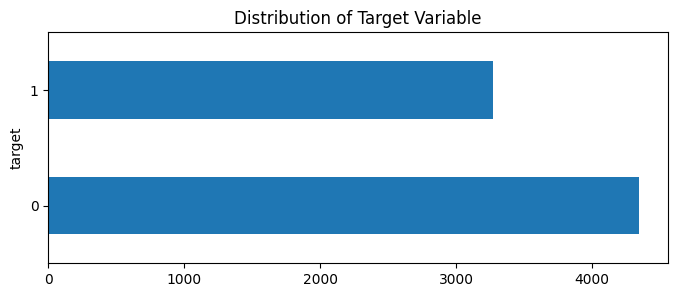

In [11]:
train.target.value_counts().plot.barh(figsize=(8,3), title="Distribution of Target Variable")
plt.show()

We have **more** `Non Disaster` tweets than `Disaster` tweets.

### Distribution of words in tweets

In [12]:
# Calculate the number of words per tweet
train["words_per_tweet"] = train.text.apply(lambda x: len(x.split()))

In [13]:
def plot_distribution(data, title):
    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,5))

    # Plot the histogram 
    ax[0].hist(data.words_per_tweet, bins=20)

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=data.words_per_tweet.min(), color = 'gray', linestyle='dashed', linewidth = 2, label = 'min')
    ax[0].axvline(x=data.words_per_tweet.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'mean')
    ax[0].axvline(x=data.words_per_tweet.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'median')
    ax[0].axvline(x=data.words_per_tweet.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'mode')
    ax[0].axvline(x=data.words_per_tweet.max(), color = 'gray', linestyle='dashed', linewidth = 2, label = 'max')

    # Plot the boxplot
    ax[1].boxplot(train.words_per_tweet, vert=False)

    # Add a title to the Figure
    fig.suptitle(title)

    # Legend
    ax[0].legend()

    # Show the figure
    fig.show()

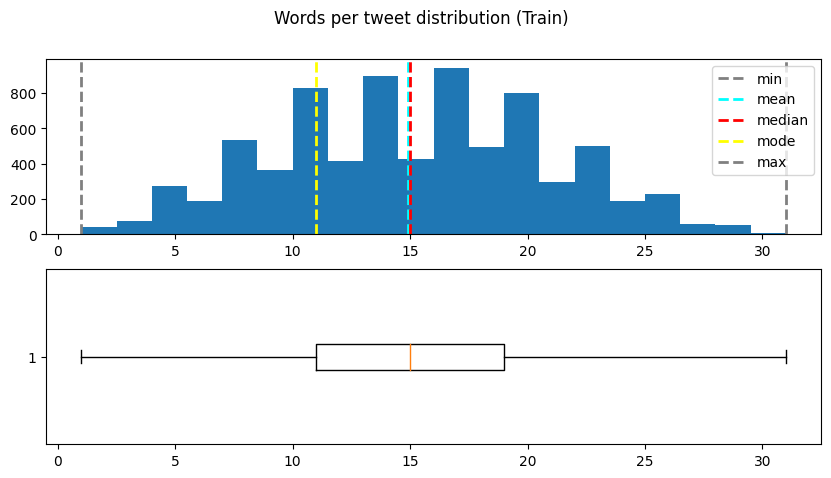

In [14]:
# Distribution of words per tweet
plot_distribution(train, "Words per tweet distribution (Train)")

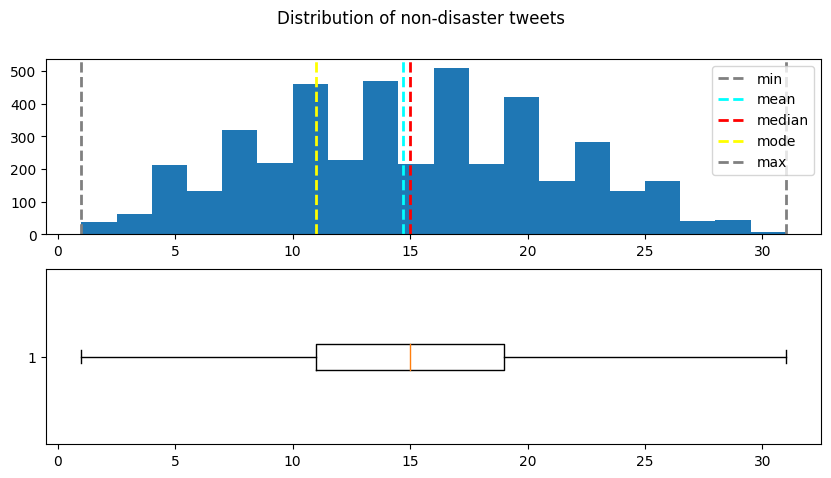

In [15]:
# Distribution of words per tweet for non-disaster tweets
plot_distribution(train[train.target == 0], "Distribution of non-disaster tweets")

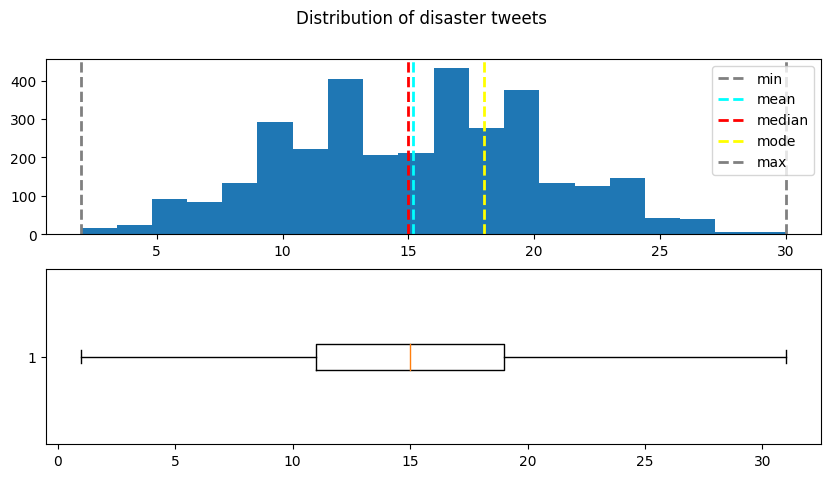

In [16]:
# Distribution of words per tweet for disaster tweets
plot_distribution(train[train.target == 1], "Distribution of disaster tweets")

### Remove Stopwords

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wizard/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.lower().split() if word not in STOPWORDS])

In [19]:
# Remove stopwords
train['processed_text'] = train['text'].apply(lambda x: remove_stopwords(x))

### Top 50 words in the corpus

In [20]:
def plot_top_tokens(df, col, hue=None, top_n=50, title=None):
    """Plot the top n tokens in text feature"""
    # Get top n tokens
    target_label = {
        0: 'Not Disaster',
        1: 'Disaster'
    }

    if not hue:
        top_tokens = df[col].str.split(expand=True).stack().value_counts()[:top_n]
        # Plot
        fig, ax = plt.subplots(figsize=(8, 8))
        sns.barplot(x=top_tokens.values, y=top_tokens.index, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Count')
        ax.set_ylabel('Token')
        plt.show()
    else:
        fig, ax = plt.subplots(1, 2, figsize = (15,10))
        for i in range(2):
            top_tokens = df[df.target == i][col].str.split(expand=True).stack().value_counts()[:top_n]
            sns.barplot(x=top_tokens.values, y=top_tokens.index, ax=ax[i])
            ax[i].set_title(title + ': ' + target_label[i] )
            ax[i].set_xlabel('Count')
            ax[i].set_ylabel('Token')
        plt.tight_layout()
        plt.show()

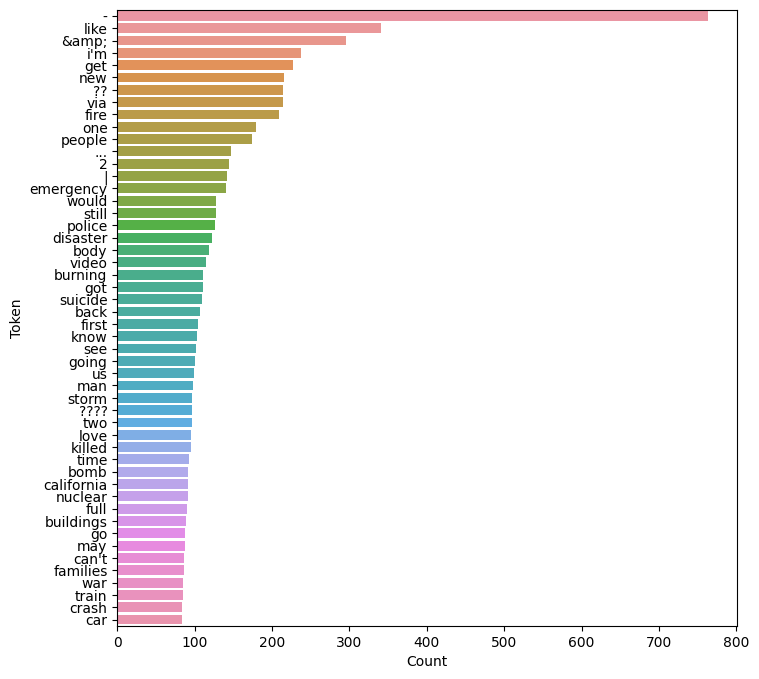

In [21]:
plot_top_tokens(train, 'processed_text')

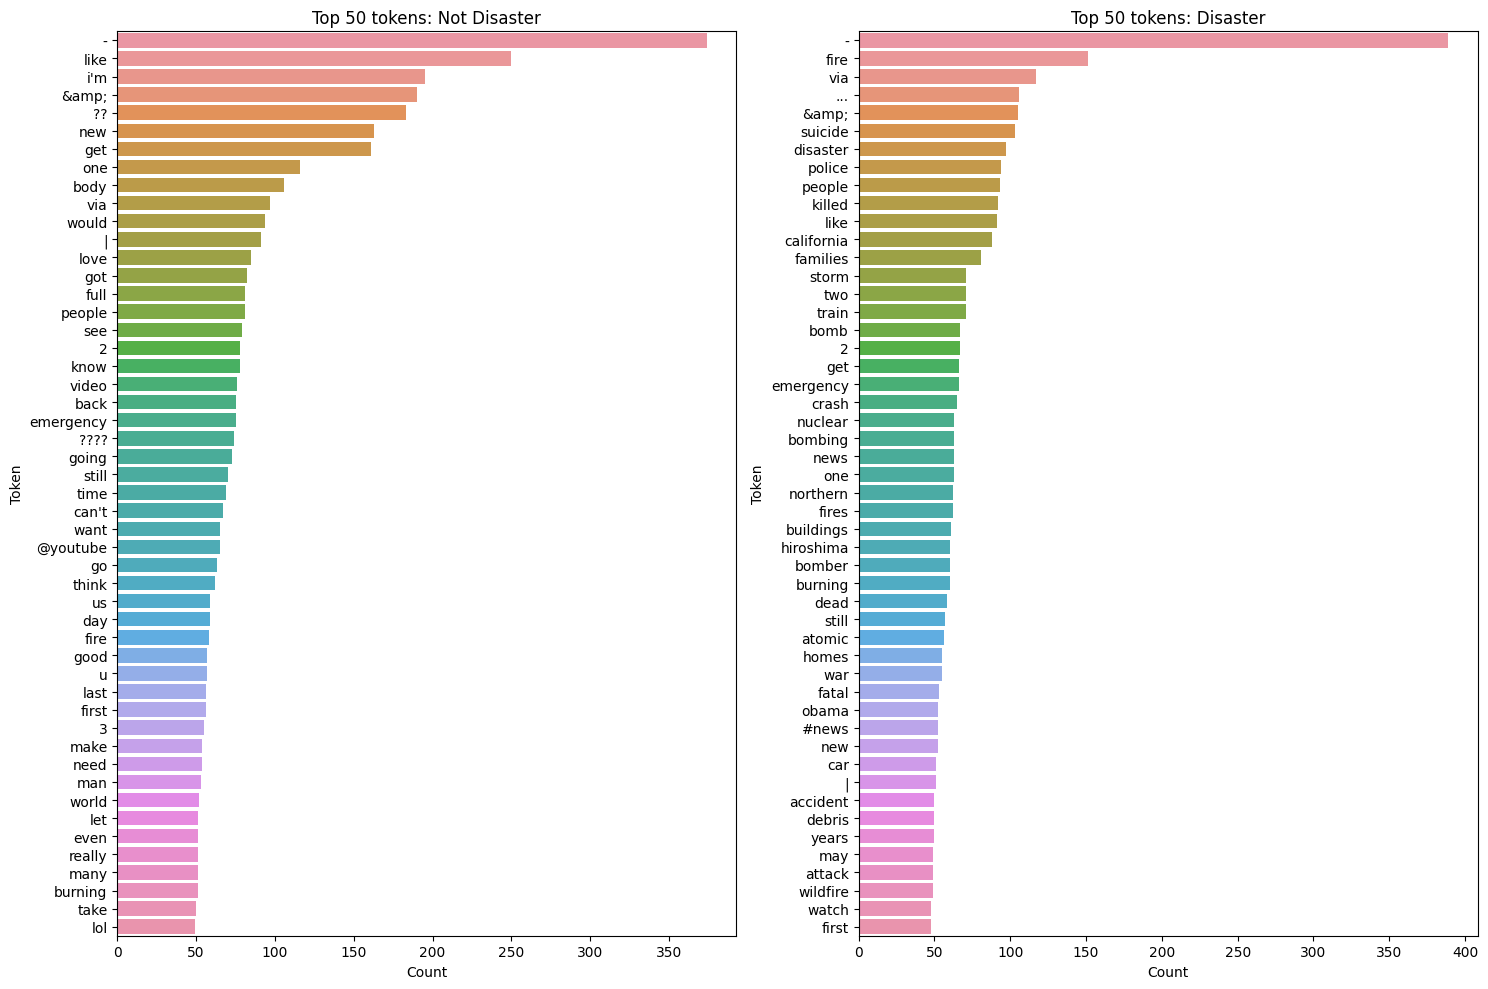

In [22]:
plot_top_tokens(train, 'processed_text', hue=True, title='Top 50 tokens')

In [23]:
def count_ngrams(df, n, top_n=50, hue=False):
    target_label = {
        0: 'Not Disaster',
        1: 'Disaster'
    }
    if not hue:
        itr = nltk.ngrams(df['processed_text'].str.split().explode(), n)
        fdist = nltk.FreqDist(itr).most_common(top_n)
        top_values = dict(fdist)
        top_values = pd.DataFrame({
            'ngram': [" ".join(ngram) for ngram in list(top_values.keys())],
            'count': list(top_values.values())
        })
        plt.figure(figsize=(8, 8))
        sns.barplot(y=top_values['ngram'], x=top_values['count'], orient='h')
        plt.title("Top {} {}-grams".format(top_n, n))
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 2, figsize = (15,10))
        for i in range(2):
            itr = nltk.ngrams(df[df.target == i]['processed_text'].str.split().explode(), n)
            fdist = nltk.FreqDist(itr).most_common(top_n)
            top_values = dict(fdist)
            top_values = pd.DataFrame({
                'ngram': [" ".join(ngram) for ngram in list(top_values.keys())],
                'count': list(top_values.values())
            })
            
            sns.barplot(y=top_values['ngram'], x=top_values['count'], orient='h', ax=ax[i])
            ax[i].set_title("Top {} {}-grams: {}".format(top_n, n, target_label[i]))
        plt.tight_layout()
        plt.show()

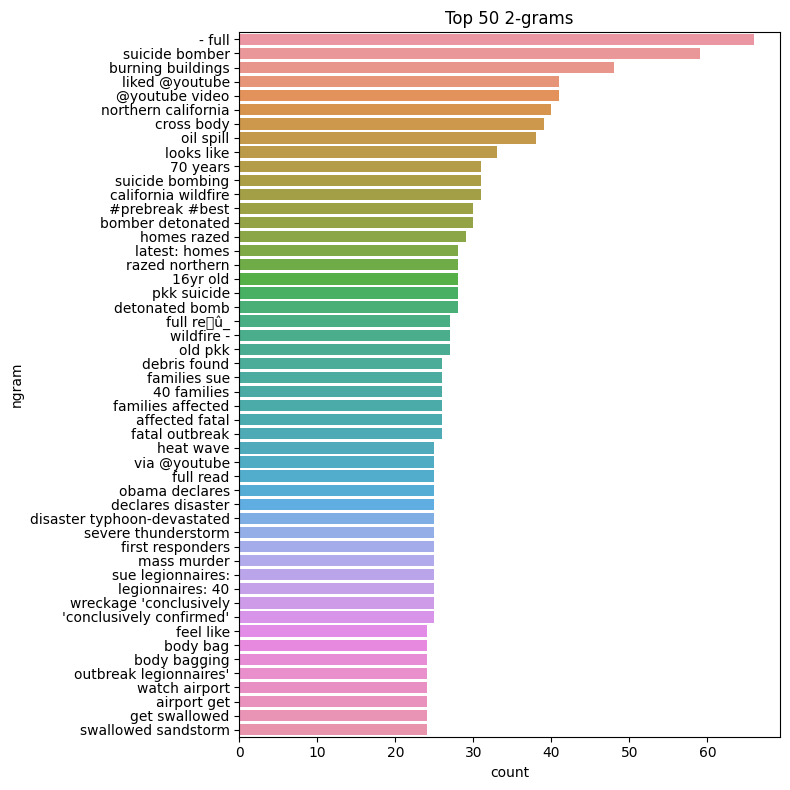

In [24]:
# 2-gram analysis
count_ngrams(train, 2)

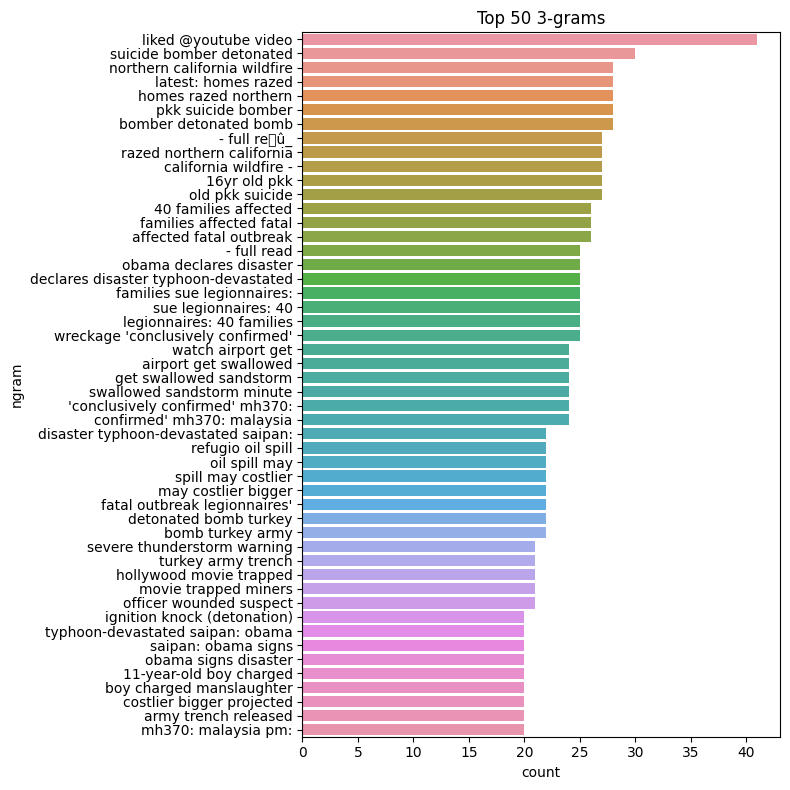

In [25]:
# 3-grams analysis
count_ngrams(train, 3)

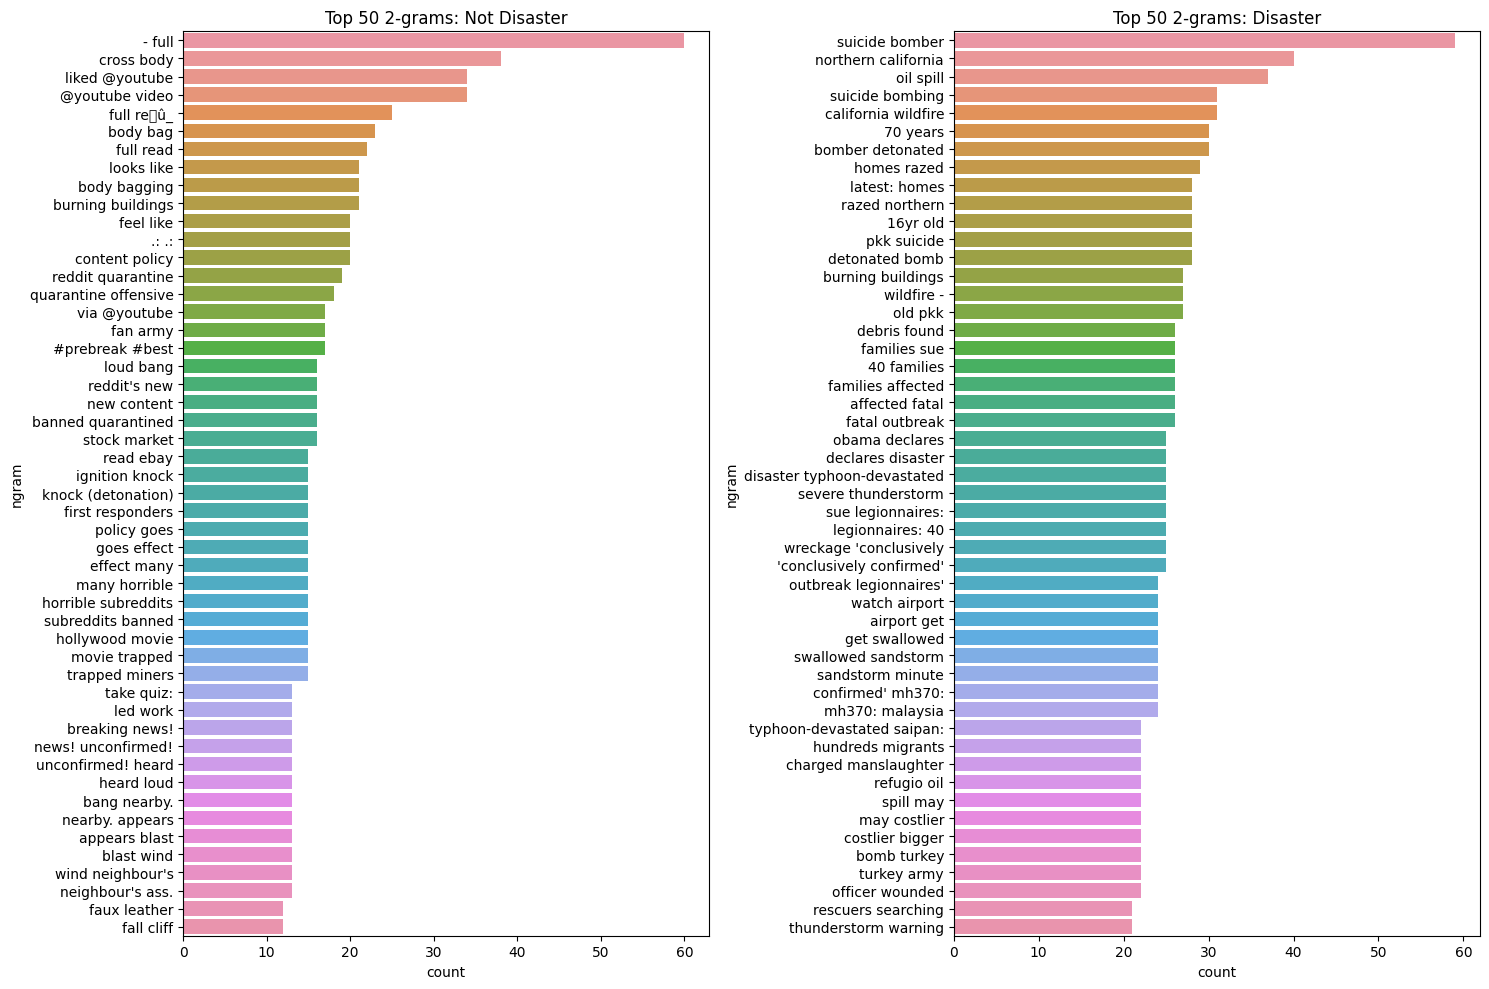

In [26]:
# 2-grams analysis by target variable
count_ngrams(train, 2, hue=True)

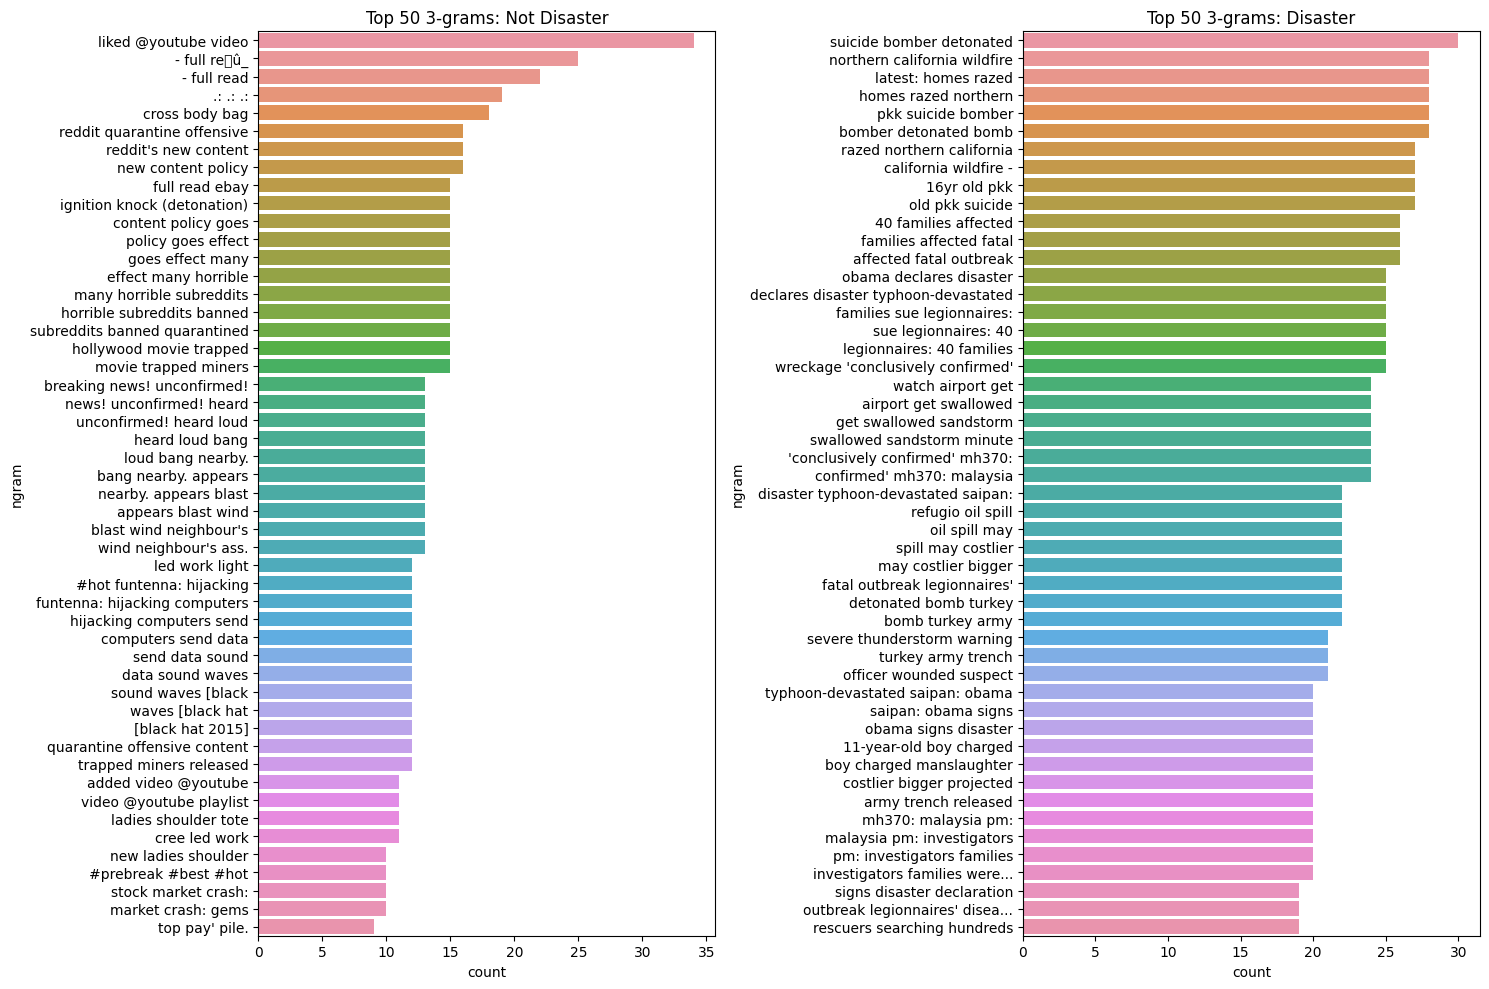

In [27]:
# 3-grams analysis by target variable
count_ngrams(train, 3, hue=True)